In [26]:
import cv2
import os
import numpy as np
import mediapipe as mp
from scipy.signal import butter, detrend, filtfilt, find_peaks
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

In [27]:
def process_video_and_extract_signal(video_path):
    """
    处理视频文件，提取人脸额头区域的原始 rPPG 信号。
    """
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"无法打开视频文件: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    raw_signal = []
    timestamps = []
    
    print(f"\n--- 开始处理视频: {os.path.basename(video_path)} ---")
    print(f"帧率: {fps:.2f} FPS, 总帧数: {frame_count}")

    frame_num = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)

        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0].landmark
            forehead_indices = [103, 104, 65, 66, 105, 107]
            h, w, _ = frame.shape
            forehead_points = np.array([(landmarks[i].x * w, landmarks[i].y * h) for i in forehead_indices], dtype=np.int32)
            
            mask = np.zeros_like(frame[:, :, 0])
            cv2.fillConvexPoly(mask, forehead_points, 255)
            
            green_channel = frame[:, :, 1]
            mean_green = cv2.mean(green_channel, mask=mask)[0]
            
            raw_signal.append(mean_green)
            timestamps.append(frame_num / fps)
        else:
            raw_signal.append(np.mean(raw_signal) if raw_signal else 0)
            timestamps.append(frame_num / fps)

        frame_num += 1
        if frame_num % 100 == 0:
            print(f"  已处理 {frame_num}/{frame_count} 帧...")

    cap.release()
    face_mesh.close()
    print("--- 视频处理完成，原始信号提取完毕 ---")
    
    return np.array(raw_signal), np.array(timestamps), fps


def process_rppg_signal(signal, fps):
    """
    对提取的原始 rPPG 信号进行去趋势、滤波和归一化处理。
    """
    detrended_signal = detrend(signal)
    low_cutoff, high_cutoff = 0.7, 4.0
    nyquist = 0.5 * fps
    b, a = butter(2, [low_cutoff/nyquist, high_cutoff/nyquist], btype='band')
    filtered_signal = filtfilt(b, a, detrended_signal)
    normalized_signal = (filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal)
    return normalized_signal


def calculate_bpm_over_time(bvp_signal, fps, window_sec=6, step_sec=1):
    """
    使用滑动窗口和 FFT 计算随时间变化的心率 (BPM)。
    """
    bpm_list, bpm_times = [], []
    window_samples = int(window_sec * fps)
    step_samples = int(step_sec * fps)
    
    for i in range(0, len(bvp_signal) - window_samples, step_samples):
        window = bvp_signal[i : i + window_samples]
        window = window * np.hanning(len(window))
        
        N = len(window)
        yf = rfft(window)
        xf = rfftfreq(N, 1 / fps)
        
        valid_indices = np.where((xf >= 0.7) & (xf <= 4.0))
        if len(valid_indices[0]) == 0: continue
            
        peak_freq_index = valid_indices[0][np.argmax(np.abs(yf[valid_indices]))]
        peak_freq = xf[peak_freq_index]
        
        bpm = peak_freq * 60
        bpm_list.append(bpm)
        bpm_times.append((i + window_samples / 2) / fps)
        
    return np.array(bpm_list), np.array(bpm_times)

def analyze_hrv(bvp_signal, fps):
    """
    分析 BVP 信号，计算 HRV 指标，并返回峰值点信息用于可视化。
    """
    # 找到 BVP 信号的峰值（代表心跳）
    peaks, _ = find_peaks(bvp_signal, height=0.5, distance=fps*0.5)
    if len(peaks) < 5:
        return None, None, None
        
    # 计算 RR 间期 (ms)
    rr_intervals = np.diff(peaks) / fps * 1000
    
    # 计算 HRV 指标
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    sdnn = np.std(rr_intervals)
    
    hrv_metrics = {'RMSSD (ms)': rmssd, 'SDNN (ms)': sdnn}
    
    return hrv_metrics, rr_intervals, peaks

def plot_fft_spectrum(bvp_signal, fps, output_path):
    """
    绘制 BVP 信号的功率谱密度图。
    """
    N = len(bvp_signal)
    yf = rfft(bvp_signal * np.hanning(N))
    xf = rfftfreq(N, 1 / fps)
    
    plt.figure(figsize=(10, 5))
    plt.plot(xf * 60, np.abs(yf))
    plt.title('FFT Power Spectrum of BVP Signal')
    plt.xlabel('Frequency (BPM)')
    plt.ylabel('Power')
    plt.xlim(40, 200)
    plt.grid(True)
    plt.savefig(output_path)
    plt.show()

def plot_poincare(rr_intervals, output_path):
    """
    绘制 HRV 的庞加莱图。
    """
    rr_i = rr_intervals[:-1]
    rr_i_plus_1 = rr_intervals[1:]
    
    plt.figure(figsize=(6, 6))
    plt.scatter(rr_i, rr_i_plus_1, alpha=0.5)
    plt.title('Poincaré Plot of RR Intervals')
    plt.xlabel('RRi (ms)')
    plt.ylabel('RRi+1 (ms)')
    min_val, max_val = min(rr_i.min(), rr_i_plus_1.min()), max(rr_i.max(), rr_i_plus_1.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Line of Identity')
    plt.grid(True); plt.axis('square'); plt.savefig(output_path); plt.show()
    
def calculate_errors(estimated_bpm, estimated_times, gt_bpm, gt_times):
    """
    计算 RMSE 和 MAE 评估指标。
    """
    interpolated_gt_bpm = np.interp(estimated_times, gt_times, gt_bpm)
    rmse = np.sqrt(np.mean((estimated_bpm - interpolated_gt_bpm) ** 2))
    mae = np.mean(np.abs(estimated_bpm - interpolated_gt_bpm))
    return {'RMSE': rmse, 'MAE': mae}

def plot_tachogram(rr_intervals, rr_timestamps, output_path):
    """
    绘制心跳间期趋势图 (Tachogram)。
    """
    plt.figure(figsize=(12, 5))
    plt.plot(rr_timestamps, rr_intervals, marker='o', linestyle='-', label='RR Intervals')
    plt.title('Tachogram: RR Interval over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('RR Interval (ms)')
    plt.grid(True)
    plt.legend()
    plt.savefig(output_path)
    plt.show()

I0000 00:00:1758353095.881750 1507852 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1
W0000 00:00:1758353095.898696 1689124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1758353095.905540 1689124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



--- 开始处理视频: vid.avi ---
帧率: 29.26 FPS, 总帧数: 1547
  已处理 100/1547 帧...
  已处理 200/1547 帧...
  已处理 300/1547 帧...
  已处理 400/1547 帧...
  已处理 500/1547 帧...
  已处理 600/1547 帧...
  已处理 700/1547 帧...
  已处理 800/1547 帧...
  已处理 900/1547 帧...
  已处理 1000/1547 帧...
  已处理 1100/1547 帧...
  已处理 1200/1547 帧...
  已处理 1300/1547 帧...
  已处理 1400/1547 帧...
  已处理 1500/1547 帧...
--- 视频处理完成，原始信号提取完毕 ---


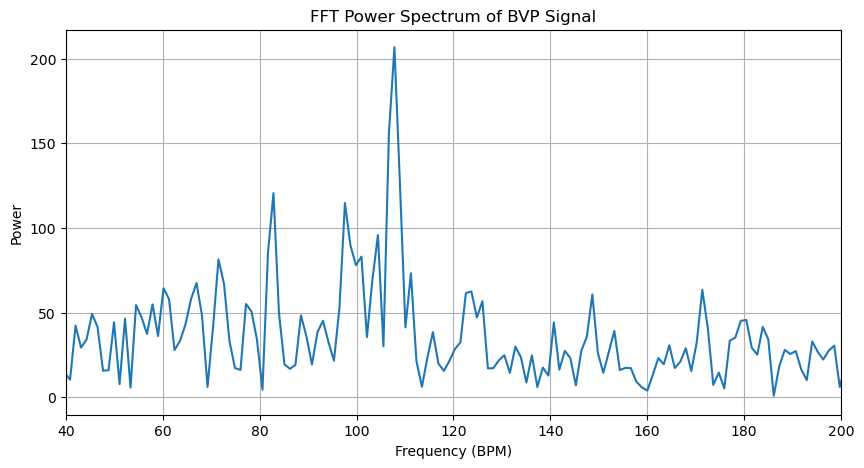


--- 心率变异性 (HRV) 分析结果 ---


,RMSSD (ms),SDNN (ms)
0,364.537031,284.63956


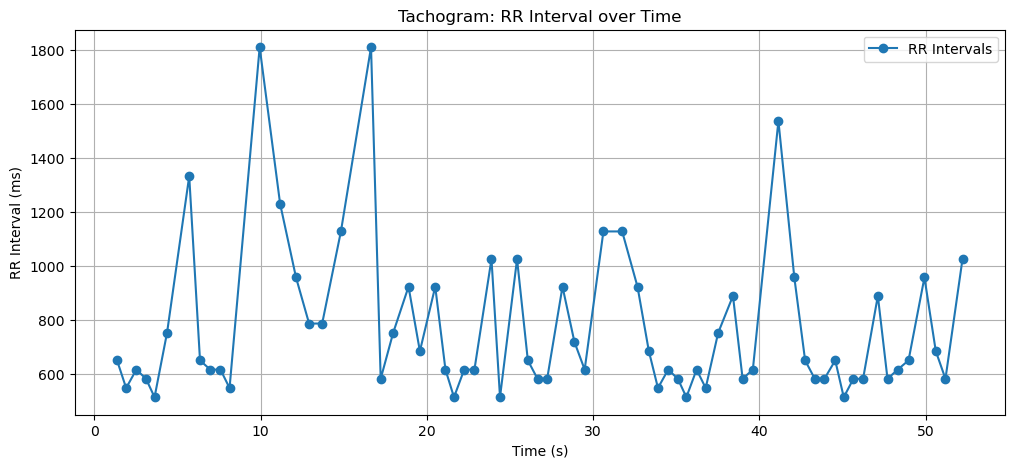

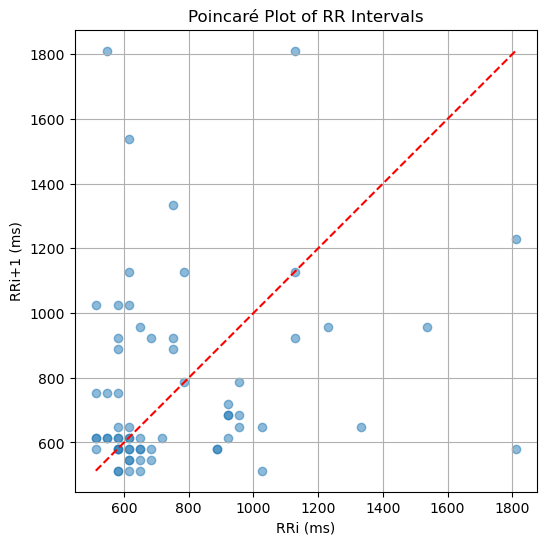

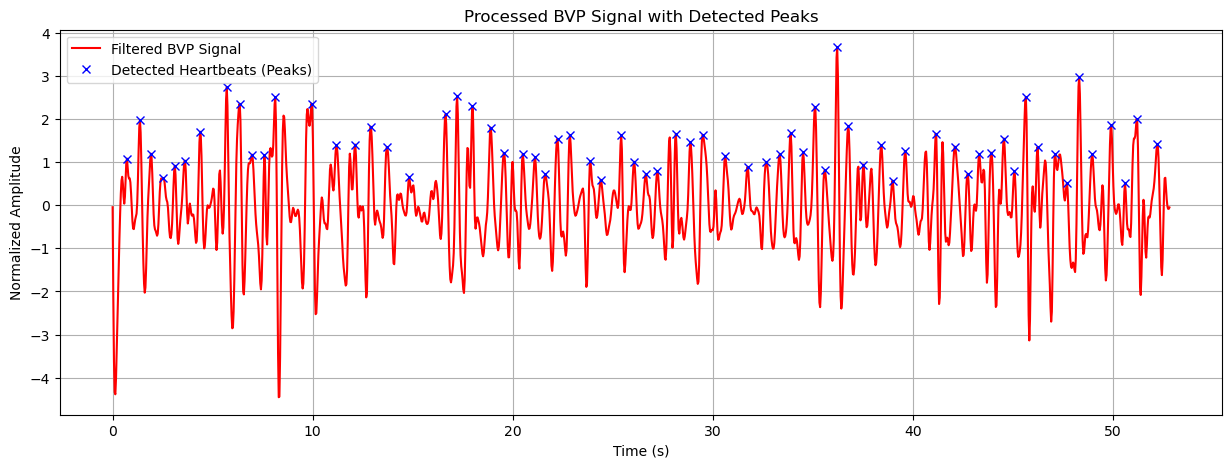

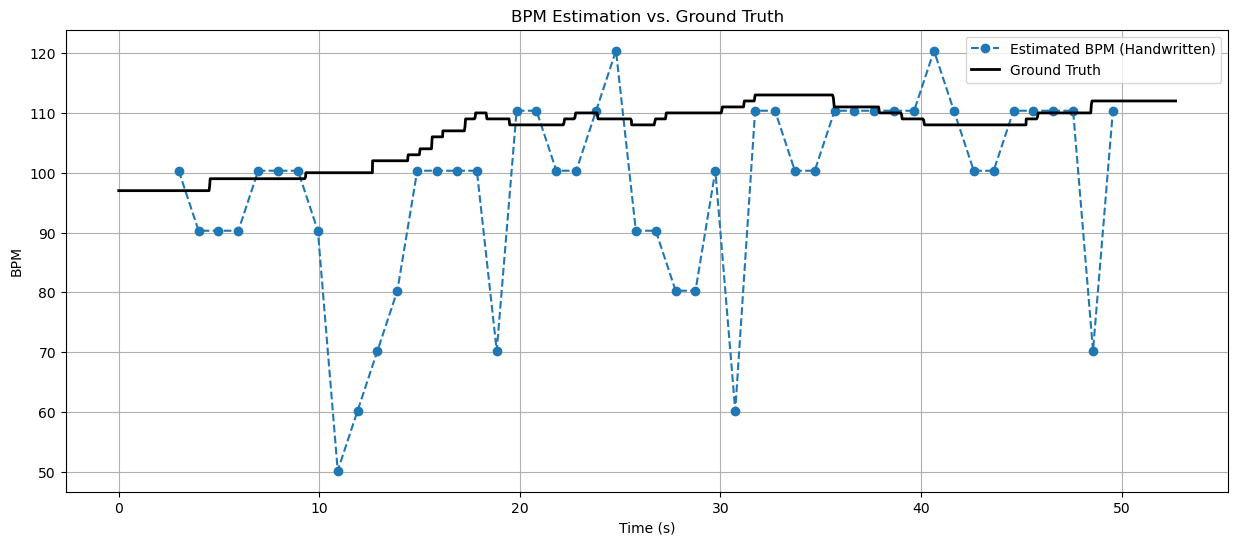

,RMSE,MAE
0,17.855668,11.459539


In [28]:
video_path = '/Users/mac/实习实践实验/shi_xi_daima/rPPG/vid.avi'
gt_path = os.path.join(os.path.dirname(video_path), 'ground_truth.txt')


raw_rppg, timestamps, video_fps = process_video_and_extract_signal(video_path)
bvp = process_rppg_signal(raw_rppg, video_fps)
bpm_estimated, bpm_times = calculate_bpm_over_time(bvp, video_fps)

gt_bpm, gt_times = None, None
if os.path.exists(gt_path):
    gt_data = np.loadtxt(gt_path)
    gt_bpm, gt_times = gt_data[1, :], gt_data[2, :]

output_folder = os.path.join('results_final', os.path.basename(os.path.dirname(video_path)))
os.makedirs(output_folder, exist_ok=True)

# 1. 绘制 FFT 功率谱
plot_fft_spectrum(bvp, video_fps, os.path.join(output_folder, 'fft_spectrum.png'))

# 2. 分析 HRV 并获取峰值点
hrv_metrics, rr_intervals, detected_peaks = analyze_hrv(bvp, video_fps)

# 3. 绘制 Tachogram 和庞加莱图
if hrv_metrics:
    print("\n--- 心率变异性 (HRV) 分析结果 ---")
    display(pd.DataFrame([hrv_metrics]))
    
    # 计算 RR 间期的时间戳用于绘图
    rr_peak_times = timestamps[detected_peaks[1:]]
    plot_tachogram(rr_intervals, rr_peak_times, os.path.join(output_folder, 'tachogram.png'))
    
    plot_poincare(rr_intervals, os.path.join(output_folder, 'poincare_plot.png'))



# 1. 绘制 BVP 信号与检测到的心跳峰值
plt.figure(figsize=(15, 5))
plt.plot(timestamps, bvp, label='Filtered BVP Signal', color='red')
if detected_peaks is not None:
    plt.plot(timestamps[detected_peaks], bvp[detected_peaks], "x", color='blue', label='Detected Heartbeats (Peaks)')
plt.title('Processed BVP Signal with Detected Peaks')
plt.xlabel('Time (s)'); plt.ylabel('Normalized Amplitude'); plt.legend(); plt.grid(True)
plt.savefig(os.path.join(output_folder, 'bvp_with_peaks.png')); plt.show()

# 2. 绘制 BPM 对比图
plt.figure(figsize=(15, 6))
plt.plot(bpm_times, bpm_estimated, label='Estimated BPM (Handwritten)', marker='o', linestyle='--')
if gt_times is not None:
    plt.plot(gt_times, gt_bpm, 'k-', label='Ground Truth', linewidth=2)
plt.title('BPM Estimation vs. Ground Truth'); plt.xlabel('Time (s)'); plt.ylabel('BPM'); plt.legend(); plt.grid(True)
plt.savefig(os.path.join(output_folder, 'bpm_comparison.png')); plt.show()

# 3. 计算并展示评估指标
if gt_times is not None:
    errors = calculate_errors(bpm_estimated, bpm_times, gt_bpm, gt_times)
    display(pd.DataFrame([errors]))